## Outline the Machine Learning model
This workflow exemplfies the proceedure to make a simple hydrological machine learning model using remote sensing data products available through Google Earth Engine. 

![ML_workflow.JPG](./Images/ML_workflow.JPG)

## Learning Objectives
In this chapter we will:

1. Select a prediction locations based on in situ USGS National Water Information Systems (NWIS) data availability
1. Connect the prediction locations to Google Earth Engine and select applicable hydrometeorological features for input into a model
1. Build python functions to enhance the processing of data
1. Plot key model inputs to develop a better understanding the model input data

## Find a Streamflow Prediction location

Go to the [USGS National Water Information System: Mapper](https://maps.waterdata.usgs.gov/mapper/index.html) and find a surface water monitoring location with ample record (>10 years).

Lets look at USGS site 10172200,  Red Butte Creek at Fort Douglass, Near SLC, UT, 10133800 East Canyon Near Park City, UT, and 10133600 Mcleod creek Near Park City, UT.

![USGS_Locations](./Images/USGS_Sites.jpg)


In [42]:
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.nwm_client import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import Get_StreamStats
from scipy import optimize
from datetime import datetime, date
%matplotlib inline
from hydrotools.nwis_client.iv import IVDataService
from hydrotools.nwm_client import utils
from progressbar import ProgressBar
import warnings
warnings.filterwarnings("ignore")

def NWIS_retrieve(site, startDT, endDT):
    service = IVDataService()
    usgs_data = service.get(
        sites=site,
        startDT= startDT,
        endDT= endDT
        )
    return usgs_data    

from platform import python_version

print(python_version())

3.9.12


In [26]:
start = '2012-01-01'
end = '2019-12-31'

#put your NWISids here!
NWISids = ['10172200', '10133800', '10133600']

#create dictionary for streams
flow = {}
for site in NWISids:
    print('Getting streamflow data for ', site)
    flow[site] = NWIS_retrieve(site, start, end)

    #make the date the index for plotting and resampling
    flow[site]['datetime'] = flow[site]['value_time']
    flow[site].set_index('datetime', inplace = True)

    #clean the data
    flow[site] = flow[site][flow[site]['value'] > 0]
    
    #resample to a daily resolution
    flow[site] = pd.DataFrame(flow[site]['value']).rename(columns = {'value':'flow_cfs'})
    flow[site] = flow[site].resample('D').mean()
    flow[site]['NWIS_site_id'] = site

Getting streamflow data for  10172200
Getting streamflow data for  10133800
Getting streamflow data for  10133600


In [35]:
flow['10172200']

,flow_cfs,NWIS_site_id
datetime,,
2012-01-03,2.471323,10172200
2012-01-04,2.470000,10172200
2012-01-05,2.465104,10172200
2012-01-06,2.390000,10172200
2012-01-07,2.390000,10172200
...,...,...
2019-12-27,1.654583,10172200
2019-12-28,1.540390,10172200
2019-12-29,1.525000,10172200


In [45]:
#save the flow dictionary
with open('./Data/Processed/flow.pkl', 'wb') as handle:
    pickle.dump(flow, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
#Read in dictionary
with open('./Data/Processed/flow.pkl', 'rb') as handle:
    flow = pickle.load(handle)

## Dataframe check
Lets explore the data:

1. What is the temporal resolution?
2. What are the dataframe headers/columns?
3. What variable are we seeing and in what units?
4. How many observations are there?

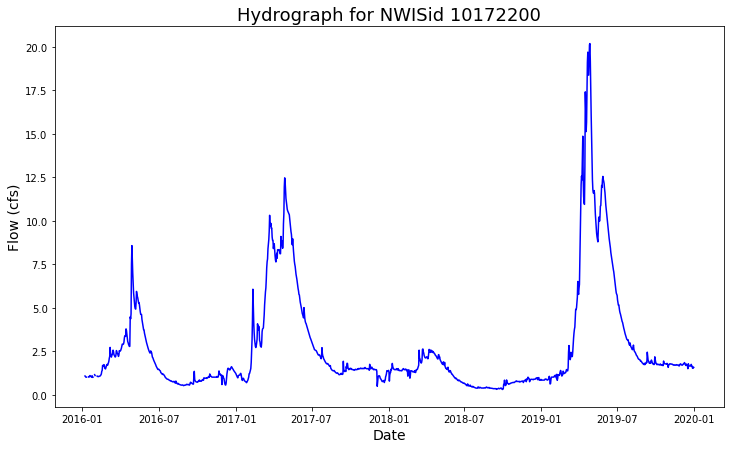

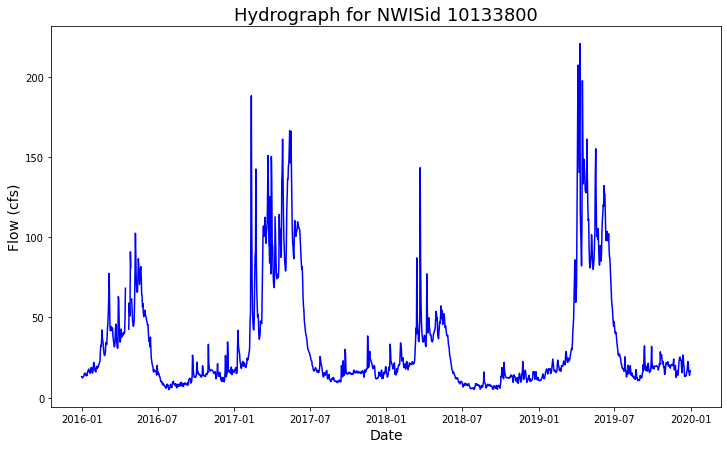

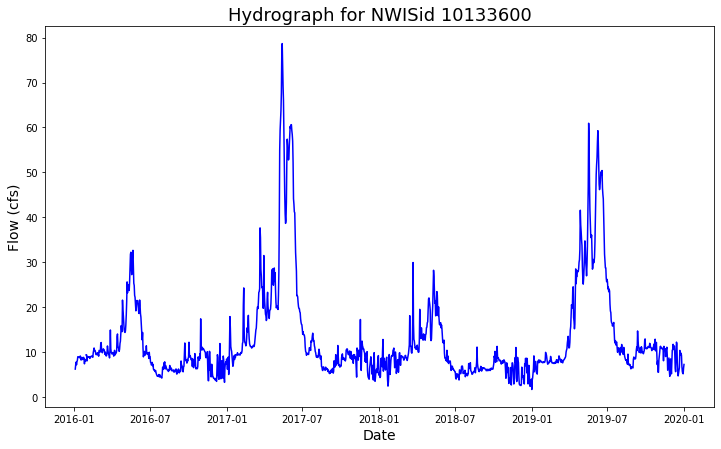

In [23]:

for site in NWISids:
# Subplots.
    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    fig.patch.set_facecolor('white')

    #set min/max for y-axis
    #y-axis
    ymin = min(flow[site]['flow_cfs'])*1.1
    ymax = max(flow[site]['flow_cfs'])*1.1
    title = 'Hydrograph for NWISid '+site

    #set colors
    color_f = 'blue'


    # Add flow to plot.
    ax.plot(flow[site].index, flow[site]['flow_cfs'],
               c=color_f, label='Flow (cfs)')
    ax.set_ylabel('Flow (cfs)', fontsize = 14)
    ax.set_xlabel('Date',  fontsize = 14)
    ax.set_title(title, fontsize = 18)

    plt.show()

In [24]:
def hydrographs(flow, NWISids):
    # Subplots.
    fig, ax = plt.subplots(1,1, figsize=(12, 7))
    fig.patch.set_facecolor('white')

    #set colors
    color_f = 'blue'


    # Add flow to plot.
    for site in NWISids:
        ax.plot(flow[site].index, flow[site]['flow_cfs'], label= site)
    ax.set_ylabel('Streamflow (cfs)', fontsize = 14)
    ax.set_xlabel('Date',  fontsize = 14)
    ax.set_title('Hydrographs', fontsize = 18)
    ax.legend()

    plt.show()

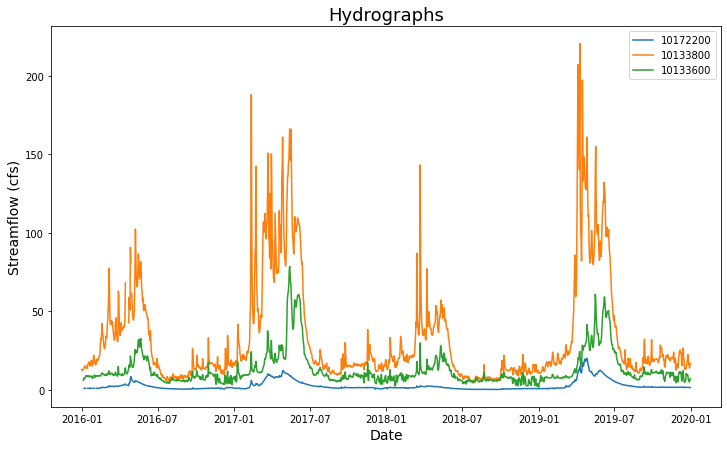

In [25]:
hydrographs(flow, NWISids)

## Catchment Characteristics
Streamflow is highly correlated to the underlying catchment characteristics, such as:
1. Area
2. Elevation
3. Land Cover
4. Water resources infrastructure (dams, diversions, etc.)

Lets get some catchment statistics using [StreamStats](https://streamstats.usgs.gov/ss/)

![StreamStats](./Images/StreamStats.JPG)


In [ ]:
#Use the Get_StreamStats functions to get StreamStats information
StreamStats = Get_StreamStats.get_USGS_site_info(NWISids, Preloaded_data =True)

#save dataframe for further use
StreamStats.to_csv('./Data/StreamStats3.csv')

Calculating NWIS streamflow id characteristics for  3 sites
NWIS site:  10172200


In [11]:
StreamStats = pd.read_csv('./Data/StreamStats2.csv')
StreamStats['NWIS_site_id'] = StreamStats['NWIS_site_id'].astype('str')
StreamStats.pop('Unnamed: 0')
StreamStats

,NWIS_site_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in
0,10172200,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6
1,10133800,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2
2,10133600,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5


In [12]:
StreamStats['NWIS_site_id'].dtype

dtype('O')

Lets take a look at the catchment characteristics of these sites. Are all of the observations present? If not, they may need to be manually added using [StreamStats](https://streamstats.usgs.gov/ss/)

In [13]:
StreamStats

,NWIS_site_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in
0,10172200,40.779946,-111.806045,7.22,6810.0,43.1,0.0,0.00359,8.68,88.3,35.6
1,10133800,40.759670,-111.564091,64.60,7420.0,65.4,13.1,3.65000,2.63,36.3,26.2
2,10133600,40.688039,-111.533719,16.30,7890.0,69.5,14.3,4.08000,1.62,48.3,21.5


![GEE](./Images/GEE.png)

# Use Google Earth Engine to collect data for a point

[Google Earth Engine catalog](https://developers.google.com/earth-engine/datasets/catalog/) offers an assortment of ready to use remote sensing products.
Before using GEE in Jupyter, you will need to install GEE for Jupyter using this [link](https://developers.google.com/earth-engine/guides/python_install) while following the [Conda](https://developers.google.com/earth-engine/guides/python_install-conda) instructions as well as following the installation guide [Google Earth Engine](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).
Note, you must have an active gmail account to use GEE.

In [15]:
#Connect to Earth Engine to get NLDAS Temperature and Precipitation
import ee
import EE_funcs
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1Adeu5BXy2nuHC5px0ugm6kaMgK4RS8LBcPKmv90WVZfsT2DQtI856_JeMLk

Successfully saved authorization token.


### Lets get some data

[NLDAS](https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002#bands) precipitation and temperature

In [28]:
#NLDAS temperature
temp = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('temperature').filterDate(start, end)

#NLDAS precipitation
precip = ee.ImageCollection('NASA/NLDAS/FORA0125_H002').select('total_precipitation').filterDate(start, end)


In [29]:
# Define slc location of interest, lets use the USGS guage locations!
lon = {}
lat = {}
poi = {}

for site in np.arange(0,len(NWISids),1):
    lon[site] = StreamStats['Long'][site]
    lat[site] = StreamStats['Lat'][site]
    poi[site] = ee.Geometry.Point(lon[site], lat[site])

scale = 1000  # scale in meters

In [12]:
# Calculate and print the mean value of the LST collection at the point.
for site in np.arange(0,len(NWISids),1):
    site_temp = temp.mean().sample(poi[site], scale).first().get('temperature').getInfo()
    print('Average daytime temperature at USGS Station: ', StreamStats['NWIS_site_id'][site], ' is ',   round(site_temp, 2), '°C')

Average daytime temperature at USGS Station:  10172200  is  8.44 °C
Average daytime temperature at USGS Station:  10133800  is  6.91 °C
Average daytime temperature at USGS Station:  10133600  is  5.52 °C


In [13]:
# Calculate and print the mean value of the precip collection at the point.
kg_in = 0.04
for site in np.arange(0,len(NWISids),1):
    site_precip = precip.mean().sample(poi[site], scale).first().get('total_precipitation').getInfo()
    print('Average hourly precipitation at USGS Station: ', StreamStats['NWIS_site_id'][site], ' is ', round(site_precip*kg_in, 4), 'in')

Average hourly precipitation at USGS Station:  10172200  is  0.0022 in
Average hourly precipitation at USGS Station:  10133800  is  0.0034 in
Average hourly precipitation at USGS Station:  10133600  is  0.0041 in


In [30]:
# Get the data for the pixel intersecting the point at each station
temp_poi = {}
precip_poi = {}

pbar = ProgressBar()
for site in pbar(np.arange(0,len(NWISids),1)):
    name = StreamStats['NWIS_site_id'][site]
    temp_poi[name] = temp.getRegion(poi[site], scale).getInfo()
    precip_poi[name] = precip.getRegion(poi[site], scale).getInfo()


# Preview the result.
temp_poi['10172200'][:5]

[['id', 'longitude', 'latitude', 'time', 'temperature'],
 ['A20120101_0000',
  -111.80881183793625,
  40.77902232260568,
  1325376000000,
  -3.519999999999982],
 ['A20120101_0100',
  -111.80881183793625,
  40.77902232260568,
  1325379600000,
  -4.149999999999977],
 ['A20120101_0200',
  -111.80881183793625,
  40.77902232260568,
  1325383200000,
  -4.779999999999973],
 ['A20120101_0300',
  -111.80881183793625,
  40.77902232260568,
  1325386800000,
  -5.409999999999968]]

In [32]:
#Convert pointer object array to dataframe to work with
temp = {}
precip = {}

pbar = ProgressBar()
for site in pbar(np.arange(0,len(NWISids),1)):
    name = StreamStats['NWIS_site_id'][site]
    temp[name] = EE_funcs.ee_array_to_df(temp_poi[name],['temperature'])
    precip[name] = EE_funcs.ee_array_to_df(precip_poi[name],['total_precipitation'])
    #need to add in time to precip data, same daterange as temperaure
    precip[name]['time'] = temp[name]['time']

100% |########################################################################|


In [33]:
def dict_to_df(DF, temporal_resample, variable):
    var_df = pd.DataFrame()
    kg_in = 0.04
    pbar = ProgressBar()
    for site in pbar(DF):
        DF[site].set_index('datetime', inplace = True)
        
        if variable == 'temperature':
            #make columns for Fahrenheit
            DF[site] = DF[site].resample(temporal_resample).max()
            DF[site].reset_index(inplace = True)
            DF[site]['temperature_F'] = (DF[site]['temperature']*9/5)+32 
            DF[site].pop('temperature')
            DF[site]['NWIS_site_id'] = site
        if variable == 'total_precipitation':
            DF[site] = DF[site].resample(temporal_resample).sum()
            DF[site].reset_index(inplace = True)
            #make columns for inches
            DF[site]['precipitation_in'] = DF[site]['total_precipitation']*kg_in
            DF[site].pop('total_precipitation')
            DF[site]['NWIS_site_id'] = site
            
        var_df = var_df.append(DF[site])
    
    var_df.reset_index(inplace=True, drop=True)
    return var_df, DF
            
            

## For fun, define a fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

In [34]:
#resample to the desired temporal scale, take the respective statistic from the data of resampling
temporal_resample = 'D'

T, T_DF = dict_to_df(temp, temporal_resample, 'temperature')
P, P_DF = dict_to_df(precip, temporal_resample, 'total_precipitation')

Clim_DF = pd.merge(T, P,on=['datetime', 'NWIS_site_id'])
Clim_DF.pop('time')
Clim_DF

100% |########################################################################|
100% |########################################################################|


,datetime,temperature_F,NWIS_site_id,precipitation_in
0,2012-01-01,33.368,10172200,0.000000
1,2012-01-02,36.032,10172200,0.000000
2,2012-01-03,36.248,10172200,0.000000
3,2012-01-04,36.374,10172200,0.000000
4,2012-01-05,36.662,10172200,0.000000
...,...,...,...,...
8758,2019-12-26,25.484,10133600,0.079812
8759,2019-12-27,22.874,10133600,0.005784
8760,2019-12-28,17.312,10133600,0.060808
8761,2019-12-29,15.314,10133600,0.064328


In [54]:
Clim_DF.to_csv('./Data/Processed/Climate.csv')

## Lets plot the climate information

How does precipitation and temperature compare in different watersheds?


In [36]:
def temp_precip_plt(P_DF, T_DF, NWISids):
    
    # Fitting curves.
    ## Optimize the parameters using a good start p0.
    lst0 = 20
    delta_lst = 40
    tau = 365*24*3600*1000   # milliseconds in a year
    phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0


    ## First, extract x values (times) from the dfs.
    x_data_t = {}
    y_data_t = {}
    params_t = {}
    params_covariance_t = {} 


    for site in NWISids:
        P_DF[site]['time'] = T_DF[site]['time']
        x_data_t[site] = np.asanyarray(T_DF[site]['time'].apply(float))  # temperature
        y_data_t[site] = np.asanyarray(T_DF[site]['temperature_F'].apply(float))  # temperature

        #Temperature
        params_t[site], params_covariance_t[site] = optimize.curve_fit(
            fit_func, x_data_t[site], y_data_t[site], p0=[lst0, delta_lst, tau, phi])


    # Subplots.
    fig, ax = plt.subplots(2,1, figsize=(10, 10))
    fig.patch.set_facecolor('white')


    #set colors #https://matplotlib.org/stable/gallery/color/named_colors.html
    color_t = ['orange','red', 'sienna'] 
    color_p = ['deepskyblue', 'steelblue', 'blue']


    for site in np.arange(0,len(NWISids),1):
        name = StreamStats['NWIS_site_id'][site]
        # Add temperature scatter plot.
        ax[0].scatter(T_DF[name]['datetime'], T_DF[name]['temperature_F'],
                   c=color_t[site], alpha=0.35, label=name)

        # Add temperature fitting curve.
        ax[0].plot(T_DF[name]['datetime'],
                fit_func(x_data_t[name], params_t[name][0], params_t[name][1], params_t[name][2], params_t[name][3]),
                color=color_t[site], lw=2.5)
    ax[0].hlines(y=32, xmin=min(T_DF[name]['datetime']), xmax=max(T_DF[name]['datetime']), linewidth=1, 
                     color='darkblue', label = 'freezing')

    # Add some parameters.
    ax[0].set_title('Temperature for Utah Watersheds', fontsize=16, pad=40)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Temperature [$^\circ$F]', fontsize=14, color = 'red')
    ax[0].tick_params(axis='y', labelcolor='red')

    #add freezing pt horizontal line

    ax[0].grid(lw=0.2)
    ncol = len(NWISids)+1
    ax[0].legend(fontsize=14, loc='upper left', ncol = ncol, bbox_to_anchor=(0.07, 1.15))

    #now plot precipitation
    for site in np.arange(0,len(NWISids),1):
        name = StreamStats['NWIS_site_id'][site]
        # Add temperature scatter plot.
        ax[1].scatter(P_DF[name]['datetime'], P_DF[name]['precipitation_in'],
                   c=color_p[site], alpha=0.35, label=name)


    # Add some parameters.
    ax[1].set_title('Precipitation for Utah Watersheds', fontsize=16, pad=40)
    ax[1].set_xlabel('Date', fontsize=14)
    ax[1].set_ylabel('Precipitation [in]', fontsize=14, color = 'blue')
    ax[1].tick_params(axis='y', labelcolor='blue')

    ax[1].grid(lw=0.2)
    ncol = len(NWISids)+1
    ax[1].legend(fontsize=14, loc='upper left', ncol = ncol, bbox_to_anchor=(0.15, 1.15))



    fig.tight_layout()
    plt.show()

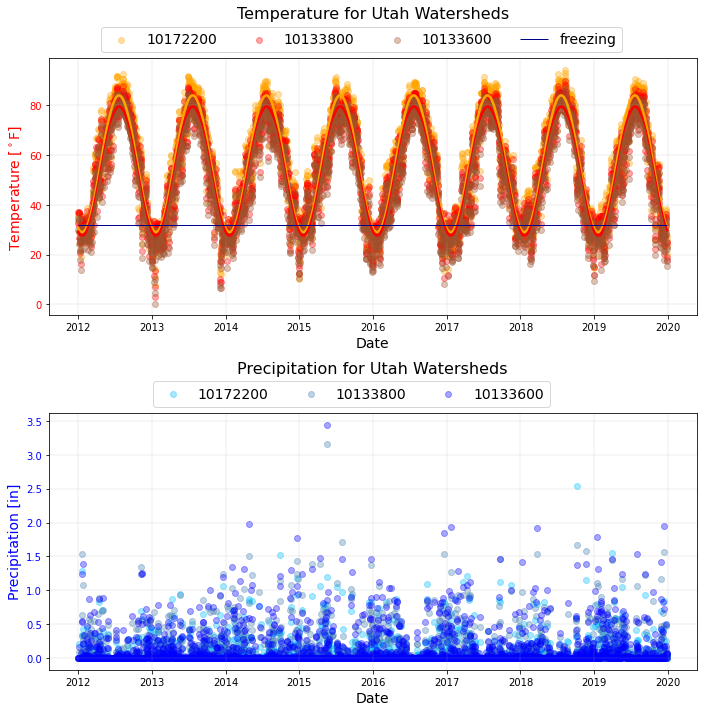

In [37]:
temp_precip_plt(P_DF, T_DF, NWISids)

## Precipitation data is not very useful here
We can distinguish the precipitation data between sites but the precipitation data is a different story.
Lets see how we can resample the data to help with this. 

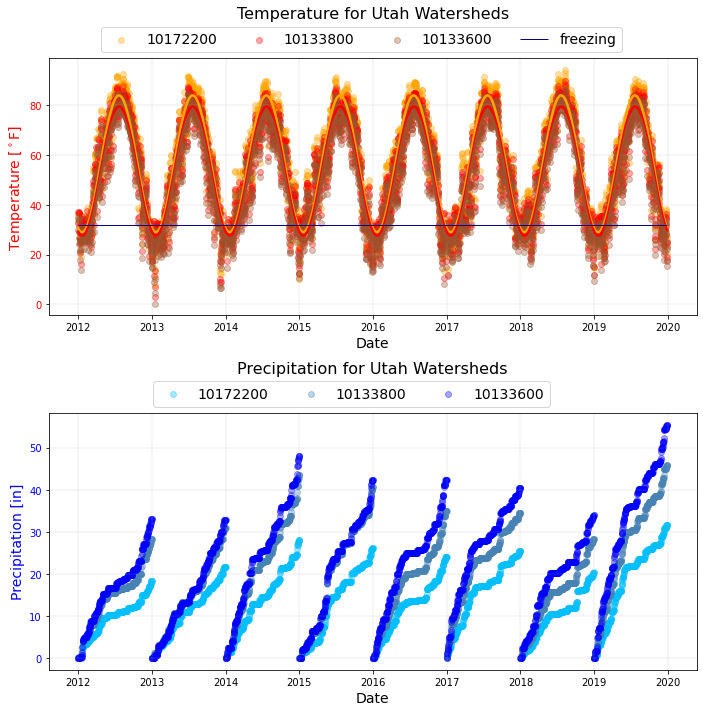

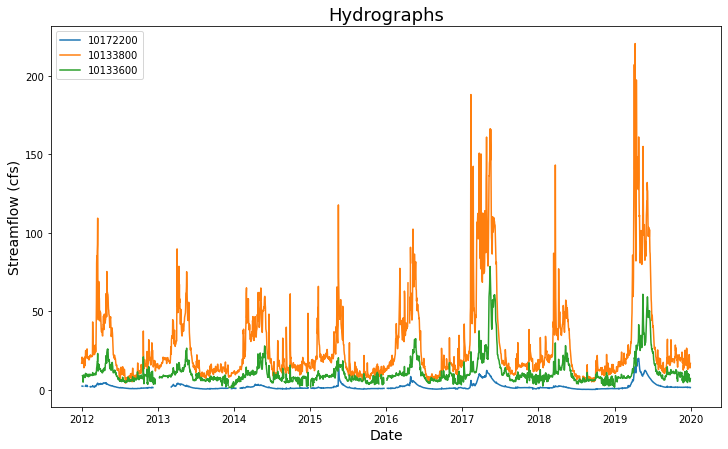

In [38]:
#Aggregate the precipitation per year
Precip_Total = {}
for site in NWISids:
    Precip_Total[site]=P_DF[site].copy()
    Precip_Total[site].set_index('datetime', inplace =True)
    Precip_Total[site].pop('time')
    Precip_Total[site]['Year'] = Precip_Total[site].index.year
    Precip_Total[site]['precipitation_in'] = Precip_Total[site].groupby(['Year'])['precipitation_in'].cumsum()
    Precip_Total[site].reset_index(inplace = True)
#lets plot again
temp_precip_plt(Precip_Total, T_DF, NWISids)
#lets plot the hydrographs again to see if we see any similarities
hydrographs(flow, NWISids)

In [50]:
#save the flow dictionary
with open('./Data/Processed/Precip_Total.pkl', 'wb') as handle:
    pickle.dump(Precip_Total, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./Data/Processed/Temperature.pkl', 'wb') as handle:
    pickle.dump(T_DF, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
#Read in data
with open('./Data/Processed/Precip_Total.pkl', 'rb') as handle:
    Precip_Total = pickle.load(handle)
    
with open('./Data/Processed/Temperature.pkl', 'rb') as handle:
    T_DF = pickle.load(handle)

## Identify co-located NWM reaches for gauge locations and collect data

In [128]:
# Function for getting NWM data
def get_NHD_Model_info(NWIS_sites):   
    print('Getting NHD reaches')
   #Get NHD reach colocated with NWIS
    NHD_reaches = []
    NWIS_NHDPlus = pd.DataFrame(columns = ['NWISid','NHDPlusid'])
    for site in NWIS_sites:
        
        
        try:
            NHD_NWIS_df = utils.crosswalk(usgs_site_codes=site)
            NHD_segment = NHD_NWIS_df.nwm_feature_id.values[0]
            NHD_reaches.append(NHD_segment)

        except:
            NHD_segment = np.nan
            NHD_reaches.append(NHD_segment)
    
    NWIS_NHDPlus['NWISid'] = NWIS_sites
    NWIS_NHDPlus['NHDPlusid'] = NHD_reaches
    
    print(NHD_reaches)
    return NHD_reaches, NWIS_NHDPlus

In [135]:
NWMreaches, NWIS_NHDPlus = get_NHD_Model_info(NWISids)

Getting NHD reaches
[nan, 10276836, 10276878]


In [234]:
def get_NWM_data(NWIS_NHDPlus, start, end):
    NWM_obs = {}
    reaches = NWIS_NHDPlus['NHDPlusid'].to_list()
    for reach in reaches:
        if reach > 1:
            r = str(int(reach))
            reachid = f"{r}_1980_2020.csv"
            filepath = f"./Data/NWM/ut/{reachid}"
            NWM_obs[r] = pd.read_csv(filepath)
            NWM_obs[r].rename(columns = {'Datetime':'datetime'}, inplace = True)
            NWM_obs[r].set_index('datetime', inplace = True)
            NWM_obs[r]=NWM_obs[r][start:end]
            NWM_obs[r] = pd.DataFrame(NWM_obs[r]['NWM_flow'])
            NWM_obs[r]['NWIS_site_id'] =  NWIS_NHDPlus['NWISid'][ NWIS_NHDPlus['NHDPlusid'] == reach].values[0]
            NWM_obs[r].reset_index(inplace = True)
        else:
            r = str(reach)
           
    return NWM_obs

In [251]:
NWM_obs = get_NWM_data(NWIS_NHDPlus, start, end)

#merge into one DF
NWM_obs_df = pd.DataFrame()
pbar = ProgressBar()
for site in pbar(NWM_obs):
    NWM_obs_df = NWM_obs_df.append(NWM_obs[site])

#convert to datetime to make sure it joins nicely with the clim_df 
NWM_obs_df['datetime'] = pd.to_datetime(NWM_obs_df['datetime'])

100% |########################################################################|


In [253]:
NWM_obs_df

,datetime,NWM_flow,NWIS_site_id
0,2012-01-01,62.286241,10133800
1,2012-01-02,62.153811,10133800
2,2012-01-03,62.006667,10133800
3,2012-01-04,61.800664,10133800
4,2012-01-05,61.741807,10133800
...,...,...,...
2917,2019-12-27,9.534960,10133600
2918,2019-12-28,9.534960,10133600
2919,2019-12-29,9.534960,10133600
2920,2019-12-30,9.534960,10133600


## Lets Create a DataFrame with all of the information for training a ML model!

We have looked at daily resolution temperature and precipitation, so lets stay at this resolution. 
The NLDAS data is available at 1 hr temporal resolution with the ability to resample to an greater timestep using the [resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) function.

The [Merge, Join, Concatenate and Compare](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) functions will be most useful here.

In [266]:
#Lets make our final dataframe with climate, streamstats, and flow
#Connect Streamstats with the climate dataframe
Training_DF = pd.merge(Clim_DF, StreamStats,on=['NWIS_site_id'])
#connect NWM flow with streamstats and climate
Training_DF = Training_DF.merge(NWM_obs_df,on=['NWIS_site_id', 'datetime'])

#Day of year (DOY) is likely an important feature, lets convert date time to DOY
Training_DF['DOY'] = Training_DF.datetime.dt.dayofyear

#now add flow, first we covert flow from a dictionary to a dataframe
Flow_DF = pd.DataFrame()
for site in NWISids:
    Flow_DF = Flow_DF.append(flow[site])
Flow_DF.reset_index(inplace = True)    
Training_DF = pd.merge(Training_DF, Flow_DF,on=['datetime', 'NWIS_site_id'])


#What feature are relevant. Lets remove NWIS_site_id
Training_DF.pop('NWIS_site_id')

#remove old datetime column
Training_DF.pop('datetime')

#drop rows with nan
Training_DF.dropna(inplace = True)

#save DataFrame for Model Development
Training_DF.to_csv('./Data/Processed/NWM_ML_Training_DF.csv')


In [268]:
Training_DF

,temperature_F,precipitation_in,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,NWM_flow,DOY,flow_cfs
0,32.738,0.000000,40.759670,-111.564091,64.6,7420.0,65.4,13.1,3.65,2.63,36.3,26.2,62.286241,1,17.019566
1,37.274,0.000000,40.759670,-111.564091,64.6,7420.0,65.4,13.1,3.65,2.63,36.3,26.2,62.153811,2,18.215624
2,36.788,0.000000,40.759670,-111.564091,64.6,7420.0,65.4,13.1,3.65,2.63,36.3,26.2,62.006667,3,20.903124
3,36.770,0.000000,40.759670,-111.564091,64.6,7420.0,65.4,13.1,3.65,2.63,36.3,26.2,61.800664,4,20.080208
4,37.004,0.000000,40.759670,-111.564091,64.6,7420.0,65.4,13.1,3.65,2.63,36.3,26.2,61.741807,5,19.657291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5833,25.484,0.079812,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,9.534960,360,6.870729
5834,22.874,0.005784,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,9.534960,361,5.743553
5835,17.312,0.060808,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,9.534960,362,5.310652
5836,15.314,0.064328,40.688039,-111.533719,16.3,7890.0,69.5,14.3,4.08,1.62,48.3,21.5,9.534960,363,5.227500


### Next Chapter
Let's put the data to use and make a [real ML model](./GEE_Workshop_CH2.ipynb)!